In [1]:
#%load_ext autoreload
#%autoreload 2

In [1]:
import pyro
from pyro.optim import Adam, ClippedAdam
from pyro.infer import TraceMeanField_ELBO, TraceEnum_ELBO, TraceGraph_ELBO, Trace_ELBO

import pandas as pd
import torch

In [2]:
from locate.simulations.simulate import simulate_segment, simulate_data
from locate.simulations.utils_simulations import plot_simulations, create_data_input

In [3]:
purity = .9
coverage = 100
ploidy = 2

segs = simulate_segment(only_clonal = True, 
                        purity = purity, 
                        coverage = coverage, 
                        genome_size = 30000000, 
                        segments = 3, 
                        CNA = ["2:1", "1:1", "2:2"])
snp,snv = simulate_data(segs)
data_input, snp, snv = create_data_input(snp, snv)

In [4]:
N = snp.shape[0]
snp['index'] = [i for i in range(N)]
bp = snp.groupby('segID').agg(min_pos=('index', 'min'), max_pos=('index', 'max')).melt(value_vars=['min_pos', 'max_pos'])
bp

,variable,value
0,min_pos,0
1,min_pos,1039
2,min_pos,1132
3,max_pos,1038
4,max_pos,1131
5,max_pos,1913


In [5]:
probs = torch.full((N,), 0.01)
probs[list(bp.value[1:-1])] = 1

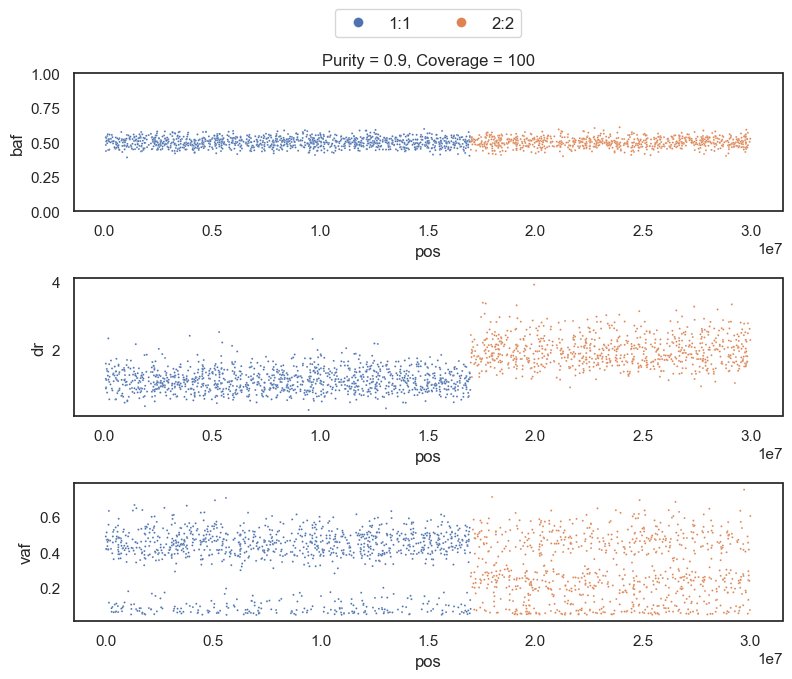

In [6]:
plot_simulations(snp, snv, purity, coverage) 

In [7]:
import locate.locate as l
from locate.models import Clonal
from locate.utils import plot_loss
from locate.utils import plot_results_simulations

In [8]:
locate = l.LOCATE(CUDA = False)

locate.set_model(Clonal)
locate.set_optimizer(ClippedAdam)
locate.set_loss(TraceEnum_ELBO)
locate.initialize_model({"baf": data_input["baf"],
                         "dr": data_input["dr"], 
                         "dp_snp": data_input["dp_snp"], 
                         "vaf": data_input["vaf"], 
                         "dp": data_input["dp"]
                         })

locate.set_model_params({"jumping_prob" : 1e-6,
                         "fix_purity": False,
                         "prior_purity": purity,
                         "prior_ploidy": ploidy,
                         "scaling_factors": [1,1,1],
                         "prior_bp": None})

/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:453.)
  _C._set_default_tensor_type(t)


In [9]:
ll = locate.run(steps = 200, param_optimizer = {"lr" : 0.05})

/Users/lucreziavaleriani/Documents/GitHub/locate/src/locate/models/Clonal.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor((1 - self._params["jumping_prob"]) * torch.eye(5) + self._params["jumping_prob"])
/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_ELBO found no sample sites configured for enumeration. If you want to enumerate sites, you need to @config_enumerate or set infer={"enumerate": "sequential"} or infer={"enumerate": "parallel"}? If you do not want to enumerate, consider using Trace_ELBO instead.
  warnings.warn(
ELBO: 5756.048986577  :   0%|          | 0/200 [00:00<?, ?it/s]/Users/lucreziavaleriani/opt/anaconda3/envs/locate/lib/python3.11/site-packages/pyro/infer/traceenum_elbo.py:355: UserWarning: TraceEnum_EL


Done!


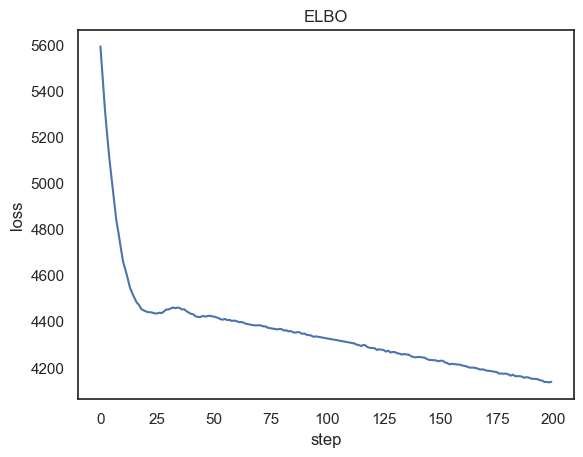

In [10]:
plot_loss(ll[0])


In [11]:
params = locate.learned_parameters_Clonal()

tensor([[1.0000e+00, 1.8652e-15, 1.8652e-15, 1.8652e-15, 1.8652e-15],
        [1.8652e-15, 1.0000e+00, 1.8652e-15, 1.8652e-15, 1.8652e-15],
        [1.5241e-15, 1.5241e-15, 1.0000e+00, 1.4984e-15, 3.1640e-09],
        [1.8570e-15, 1.8570e-15, 1.8529e-15, 1.0000e+00, 1.8291e-15],
        [2.6253e-15, 2.6253e-15, 2.6678e-10, 2.6253e-15, 1.0000e+00]],
       grad_fn=<ExpandBackward0>) torch.Size([5, 5])
tensor([[1.0000e+00, 1.8652e-15, 1.8652e-15, 1.8652e-15, 1.8652e-15],
        [1.8652e-15, 1.0000e+00, 1.8652e-15, 1.8652e-15, 1.8652e-15],
        [1.5241e-15, 1.5241e-15, 1.0000e+00, 1.4984e-15, 3.1640e-09],
        [1.8570e-15, 1.8570e-15, 1.8529e-15, 1.0000e+00, 1.8291e-15],
        [2.6253e-15, 2.6253e-15, 2.6678e-10, 2.6253e-15, 1.0000e+00]],
       grad_fn=<ExpandBackward0>) torch.Size([5, 5])


In [12]:
res = pd.DataFrame({'CN_Major':params["CN_Major"]+0.05,
                    'CN_minor':params["CN_minor"]-0.05,
                    'pos':[i for i in range(len(params["CN_minor"]))]})

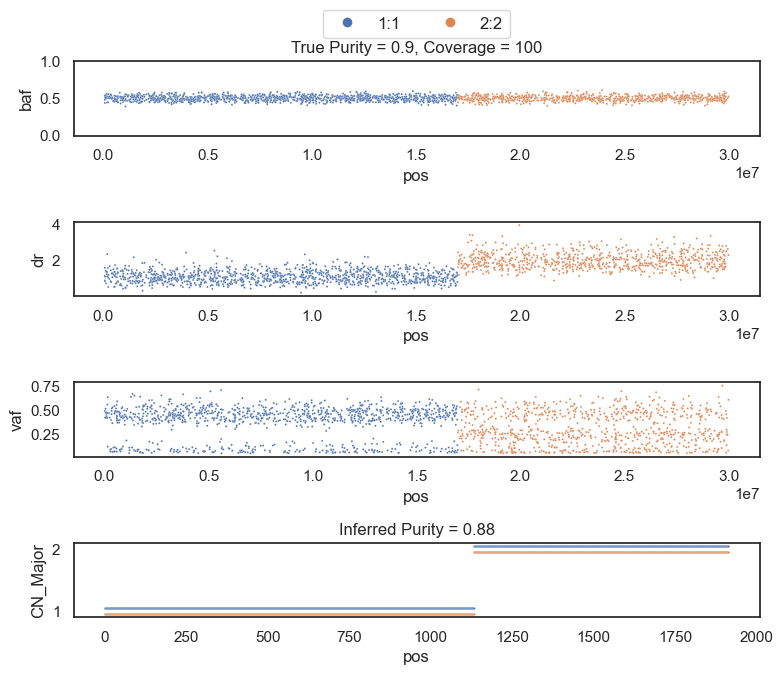

In [13]:
plot_results_simulations(snp, snv, res, params, purity, coverage)